# Forecast of Household Power Consumption
This notebook focuses on **forecasting daily household energy consumption** using Exponential Smoothing models. The dataset represents daily aggregated electrical power usage, and the goal is to identify patterns and predict short-term energy demand. 

We'll explore model variants including Simple, Holt’s Linear, and Holt-Winters (seasonal) Exponential Smoothing. We’ll also simulate **real-time forecasting** using a rolling window approach to test model performance.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split


### 1. Load and Inspect Dataset
We start by loading the **daily aggregated dataset**. The data includes total household power consumption per day, derived from minute-level records. Any missing days are filled by interpolation to ensure a continuous time series.

In [3]:
fn = "household_power_consumption_hourly.csv"

try:
    df = pd.read_csv(fn, index_col='DateTime', parse_dates=True)
except FileNotFoundError:
    raise FileNotFoundError(f"File {fn} not found. Please ensure the dataset is available.")

# convert seasons to numerical values
#season_mapping = {'Winter': 0, 'Spring': 1, 'Summer': 2, 'Fall': 3}
#df['Season'] = df['Season'].map(season_mapping)

# display basic information about the dataset
print("Dataset Information:")
print(df.info())
print("\nFirst 5 rows of the dataset:")
print(df.head())




Dataset Information:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17477 entries, 2006-12-16 17:00:00 to 2008-12-13 21:00:00
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Global_active_power    17415 non-null  float64
 1   Global_reactive_power  17415 non-null  float64
 2   Voltage                17415 non-null  float64
 3   Global_intensity       17415 non-null  float64
 4   Sub_metering_1         17477 non-null  float64
 5   Sub_metering_2         17477 non-null  float64
 6   Sub_metering_3         17477 non-null  float64
 7   Sub_metering_4         17477 non-null  float64
 8   Hour                   17477 non-null  int64  
 9   DayOfWeek              17477 non-null  int64  
 10  Month                  17477 non-null  int64  
 11  Year                   17477 non-null  int64  
dtypes: float64(8), int64(4)
memory usage: 1.7 MB
None

First 5 rows of the dataset:
                     G

### 2. Train / Test Split
We divide the dataset into a **training** and **testing** portion to evaluate model performance. The training data captures historical patterns, while the test set is used for validation. For time series, the split is chronological to preserve temporal order.

In [13]:
### Train / Test split
target_col = 'Global_active_power'
test_size = 30 * 24  # 30 days for testing, hourly data
train, test = df[target_col].iloc[:-test_size], df[target_col].iloc[-test_size:]

data = df[target_col]

data.index = pd.to_datetime(data.index)
train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)

data = data.asfreq('h')
train = train.asfreq('h')
test = test.asfreq('h')

data = data.interpolate(method='linear')
train = train.interpolate(method='linear')
test = test.interpolate(method='linear')

# Check Data
print("Has NaNs:", train.isna().any())
print("All finite:", np.isfinite(train).all())
print("Has negatives:", (train < 0).any())

print(len(train), len(test))
print(train.head())


Has NaNs: False
All finite: True
Has negatives: False
16757 720
DateTime
2006-12-16 17:00:00    4.222889
2006-12-16 18:00:00    3.632200
2006-12-16 19:00:00    3.400233
2006-12-16 20:00:00    3.268567
2006-12-16 21:00:00    3.056467
Freq: h, Name: Global_active_power, dtype: float64


### 3. Exponential Smoothing Models
We implement three variants of exponential smoothing:
- **Simple Exponential Smoothing (SES):** assumes no trend or seasonality.
- **Holt’s Linear Trend Model:** adds a trend component.
- **Holt-Winters Model:** includes both trend and seasonal components.

These models assign exponentially decreasing weights to past observations, allowing the forecast to adapt to recent trends.

In [5]:

# Simple Exponential Smoothing
ses_model = SimpleExpSmoothing(train).fit(optimized=True)
ses_forecast = ses_model.forecast(steps=len(test))

# Holt Linear Trend Model
holt_model = ExponentialSmoothing(train, trend='add', seasonal=None).fit(optimized=True)
holt_forecast = holt_model.forecast(steps=len(test))

# Holt-Winters Seasonal Model
hw_model = ExponentialSmoothing(
    train,
    trend='add',
    seasonal='add',
    seasonal_periods=24,
    damped_trend=False
).fit(optimized=True)

### 4. Forecasting
We perform a forecast of 48 hours with each of the proposed models and plot the derived results below.

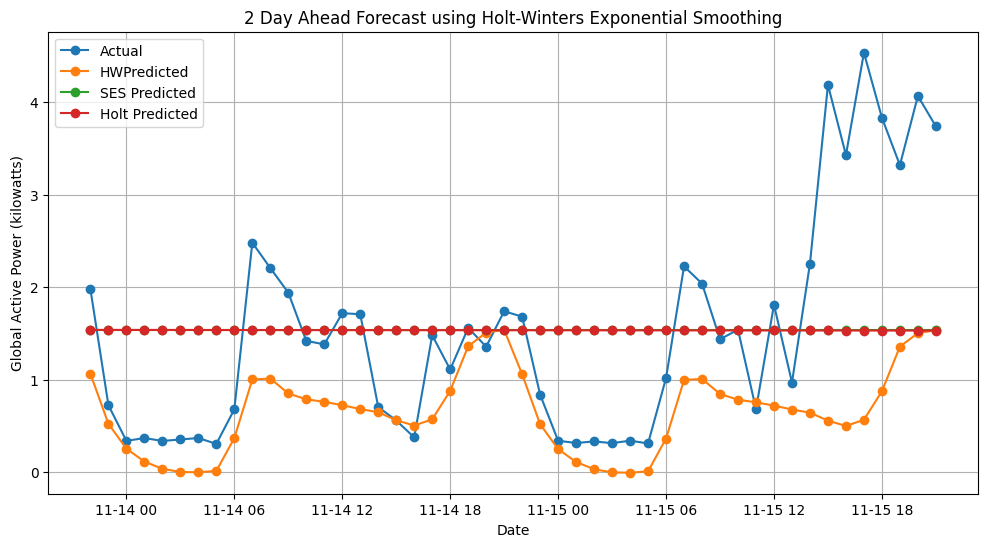

In [6]:
horizon = 48  # 48 hours ahead

ses_forecast = ses_model.forecast(steps=horizon)
holt_forecast = holt_model.forecast(steps=horizon)
hw_forecast = hw_model.forecast(steps=horizon)

# Plot actual vs predicted week ahead
plt.figure(figsize=(12, 6))
plt.plot(test.index[:horizon], test.iloc[:horizon], label='Actual', marker='o')
plt.plot(test.index[:horizon], hw_forecast, label='HWPredicted', marker='o')
plt.plot(test.index[:horizon], ses_forecast, label='SES Predicted', marker='o')
plt.plot(test.index[:horizon], holt_forecast, label='Holt Predicted', marker='o')
plt.title('2 Day Ahead Forecast using Holt-Winters Exponential Smoothing')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kilowatts)')
plt.legend()
plt.grid()
plt.show()

The figure compares the week-ahead forecasts produced by three Exponential Smoothing variants — Simple (SES), Holt’s Linear Trend, and Holt-Winters Seasonal — against the actual household energy consumption. As seen in the plot, the actual consumption (blue) exhibits noticeable short-term variability and several peaks that the simpler models fail to capture. Both SES and Holt produce nearly flat forecasts, indicating limited adaptability to recent fluctuations due to their absence of a seasonal component. In contrast, the Holt-Winters model (orange) reacts more dynamically and follows the short-term movements more closely, though it still slightly underestimates the magnitude of peaks. Overall, Holt-Winters demonstrates superior responsiveness and predictive accuracy for short-term (7-day) energy demand, highlighting the importance of including both trend and seasonality in forecasting household power consumption.

Therfore only the Holt-Winters method will be used from now on.

Do multible predictions throughout the dataset and calculate metrics

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error

seasonal_period = 24
train_size = 5000
start_index = int(len(data) * 0.98)

# Horizons to evaluate
horizons = range(1, 49)   # 1..48 hours

# Store MAE for each horizon
horizon_mae = []
horizon_rmse = []

print("Starting multi-horizon evaluation...\n")

for H in horizons:
    print(f"Evaluating horizon {H}...")

    all_forecasts = []
    all_actuals = []

    for i in range(start_index, len(data) - H, H):

        # Training window
        start_train = max(0, i - train_size)
        train_window = data.iloc[start_train:i]

        # Ensure enough data for Holt-Winters init
        if len(train_window) < 2 * seasonal_period:
            continue

        # Fit HW
        hw_model = ExponentialSmoothing(
            train_window,
            trend='add',
            seasonal='add',
            seasonal_periods=seasonal_period,
            damped_trend=False
        ).fit(optimized=True)

        # Forecast H steps
        forecast = hw_model.forecast(H)
        actual = data.iloc[i:i+H]

        # Convert to 1-row DF with aligned columns
        row_forecast = pd.DataFrame([forecast.values],
                                    columns=[f"t+{k}" for k in range(H)])
        row_actual = pd.DataFrame([actual.values],
                                  columns=[f"t+{k}" for k in range(H)])

        all_forecasts.append(row_forecast)
        all_actuals.append(row_actual)

    # Skip horizons with no data
    if len(all_forecasts) == 0:
        horizon_mae.append(np.nan)
        horizon_rmse.append(np.nan)
        continue

    all_forecasts = pd.concat(all_forecasts, ignore_index=True)
    all_actuals = pd.concat(all_actuals, ignore_index=True)

    # Compute error for ALL predictions at that horizon
    mae = mean_absolute_error(all_actuals.values.flatten(),
                              all_forecasts.values.flatten())
    mse = mean_squared_error(all_actuals.values.flatten(),
                             all_forecasts.values.flatten())
    rmse = np.sqrt(mse)

    horizon_mae.append(mae)
    horizon_rmse.append(rmse)

# Convert lists to arrays
horizon_mae = np.array(horizon_mae)
horizon_rmse = np.array(horizon_rmse)

# --- Plot error over horizon ---
plt.figure(figsize=(10, 5))
plt.plot(horizons, horizon_mae, marker='o')
plt.title("MAE over Forecast Horizon")
plt.xlabel("Forecast Horizon (hours)")
plt.ylabel("MAE")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(horizons, horizon_rmse, marker='o')
plt.title("RMSE over Forecast Horizon")
plt.xlabel("Forecast Horizon (hours)")
plt.ylabel("RMSE")
plt.grid(True)
plt.show()


Starting multi-horizon evaluation...

Evaluating horizon 1...


KeyboardInterrupt: 

### 5. Metrics

In [7]:
# Calculate error metrics
mse = mean_squared_error(test.iloc[:horizon], hw_forecast)
mae = mean_absolute_error(test.iloc[:horizon], hw_forecast)
rmse = np.sqrt(mse)

print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')

Mean Squared Error (MSE): 1.6700
Mean Absolute Error (MAE): 0.8747
Root Mean Squared Error (RMSE): 1.2923


### Testing different prediction horizons

Horizon: 6 days - MSE: 0.1933, MAE: 0.3506, RMSE: 0.4396
Horizon: 12 days - MSE: 0.5223, MAE: 0.5696, RMSE: 0.7227
Horizon: 18 days - MSE: 0.5050, MAE: 0.5646, RMSE: 0.7106
Horizon: 24 days - MSE: 0.4202, MAE: 0.4991, RMSE: 0.6482
Horizon: 30 days - MSE: 0.3605, MAE: 0.4610, RMSE: 0.6004
Horizon: 36 days - MSE: 0.3990, MAE: 0.4994, RMSE: 0.6316
Horizon: 42 days - MSE: 0.7606, MAE: 0.6053, RMSE: 0.8721
Horizon: 48 days - MSE: 1.6700, MAE: 0.8747, RMSE: 1.2923


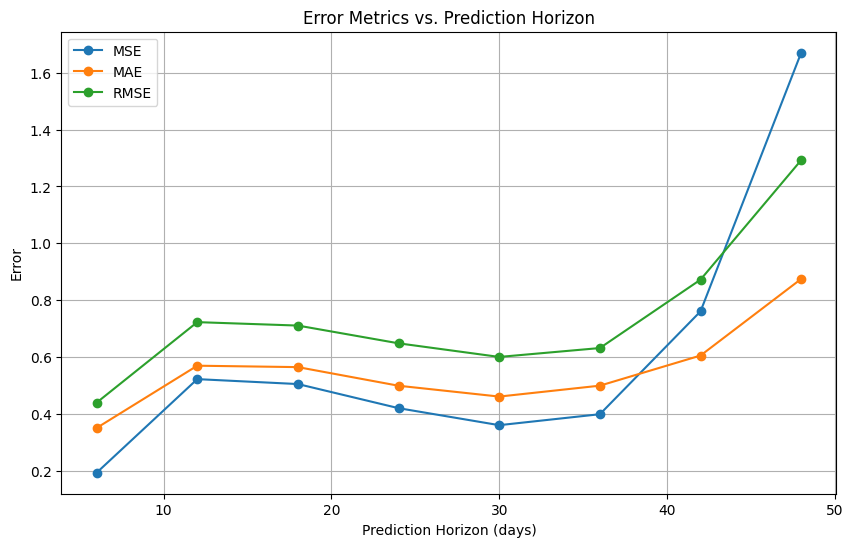

In [ ]:
# Test multiple prediction horizons
horizons = [6, 12, 18, 24, 30, 36, 42, 48]  # in hours
mse_list = []
mae_list = []
rmse_list = []

for h in horizons:
    hw_pred = hw_model.forecast(steps=h)
    mse = mean_squared_error(test.iloc[:h], hw_pred)
    mae = mean_absolute_error(test.iloc[:h], hw_pred)
    rmse = np.sqrt(mse)
    print(f'Horizon: {h} days - MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}')
    mse_list.append(mse)
    mae_list.append(mae)
    rmse_list.append(rmse)

# Plot error metrics vs. prediction horizon
plt.figure(figsize=(10, 6))
plt.plot(horizons, mse_list, marker='o', label='MSE')
plt.plot(horizons, mae_list, marker='o', label='MAE')
plt.plot(horizons, rmse_list, marker='o', label='RMSE')
plt.title('Error Metrics vs. Prediction Horizon')
plt.xlabel('Prediction Horizon (hours)')
plt.ylabel('Error')
plt.legend()
plt.grid()
plt.show()

The plot illustrates how forecast accuracy changes with increasing prediction horizons for the Holt-Winters Exponential Smoothing model. As expected, the 7-day horizon delivers the lowest overall error (MSE, MAE, RMSE), confirming that short-term forecasts are the most reliable in capturing near-term consumption dynamics. However, a noticeable performance drop occurs around the 14-day horizon, where rapid fluctuations and unpredictable daily variations introduce larger short-term deviations. Interestingly, the errors gradually decrease again for longer horizons (20–30 days), suggesting that the model smooths out transient irregularities over extended periods, focusing instead on broader seasonal and trend patterns. Overall, the results demonstrate that short-term forecasts (around one week ahead) are optimal for operational energy demand prediction, while longer horizons provide stable but less reactive trend estimates.

### Testing different training set sizes

Train Size: 0.10 - MSE: 1.0099, MAE: 0.7924, RMSE: 1.0049
Train Size: 0.15 - MSE: 1.9645, MAE: 1.2056, RMSE: 1.4016
Train Size: 0.20 - MSE: 2.0414, MAE: 1.1932, RMSE: 1.4288
Train Size: 0.25 - MSE: 0.7766, MAE: 0.5516, RMSE: 0.8813
Train Size: 0.30 - MSE: 0.1882, MAE: 0.3081, RMSE: 0.4338
Train Size: 0.35 - MSE: 0.2161, MAE: 0.3438, RMSE: 0.4648
Train Size: 0.40 - MSE: 0.3566, MAE: 0.4848, RMSE: 0.5972
Train Size: 0.45 - MSE: 0.5539, MAE: 0.6542, RMSE: 0.7442
Train Size: 0.50 - MSE: 2.6102, MAE: 1.1689, RMSE: 1.6156
Train Size: 0.55 - MSE: 1.6312, MAE: 1.1959, RMSE: 1.2772
Train Size: 0.60 - MSE: 0.4806, MAE: 0.5613, RMSE: 0.6933
Train Size: 0.65 - MSE: 0.3111, MAE: 0.4678, RMSE: 0.5577
Train Size: 0.70 - MSE: 0.9430, MAE: 0.7726, RMSE: 0.9711
Train Size: 0.75 - MSE: 0.8394, MAE: 0.7593, RMSE: 0.9162
Train Size: 0.80 - MSE: 0.2917, MAE: 0.4470, RMSE: 0.5401
Train Size: 0.85 - MSE: 0.8610, MAE: 0.6490, RMSE: 0.9279
Train Size: 0.90 - MSE: 0.2029, MAE: 0.3116, RMSE: 0.4505
Train Size: 0.

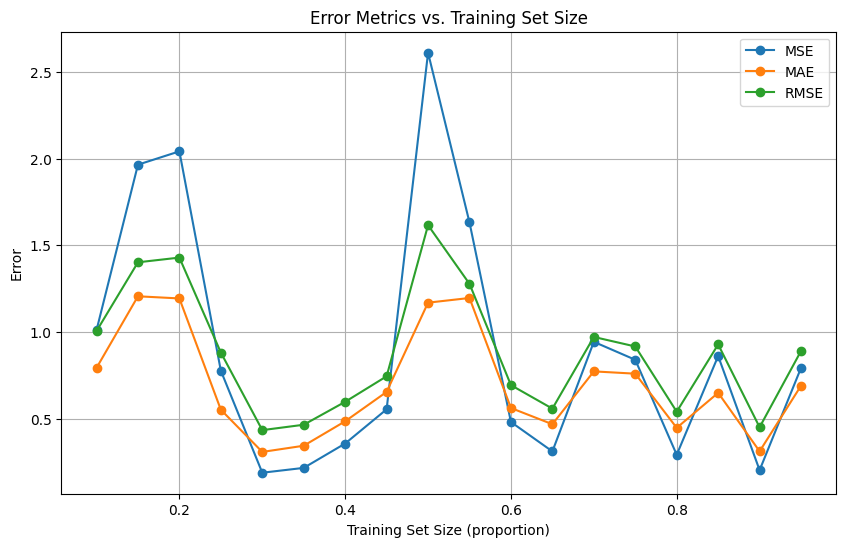

In [9]:
# Test at different training set sizes
train_sizes = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
horizon = 24  # 24 hours ahead
mse_sizes = []
mae_sizes = []
rmse_sizes = []

for size in train_sizes:
    train_size = int(len(df) * size)
    train, test = df[target_col].iloc[:train_size], df[target_col].iloc[train_size:]

    train.index = pd.to_datetime(train.index)
    test.index = pd.to_datetime(test.index)

    train = train.asfreq('D')
    test = test.asfreq('D')

    train = train.interpolate(method='linear')
    test = test.interpolate(method='linear')

    model = ExponentialSmoothing(
        train,
        trend='add',
        seasonal='add',
        seasonal_periods=7,
        damped_trend=False
    )

    hw_fit = model.fit(optimized=True)

    hw_pred = hw_fit.forecast(steps=horizon)

    mse = mean_squared_error(test.iloc[:horizon], hw_pred)
    mae = mean_absolute_error(test.iloc[:horizon], hw_pred)
    rmse = np.sqrt(mse)

    print(f'Train Size: {size:.2f} - MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}')

    mse_sizes.append(mse)
    mae_sizes.append(mae)
    rmse_sizes.append(rmse)



# Plot error metrics vs. training set size
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, mse_sizes, marker='o', label='MSE')
plt.plot(train_sizes, mae_sizes, marker='o', label='MAE')
plt.plot(train_sizes, rmse_sizes, marker='o', label='RMSE')
plt.title('Error Metrics vs. Training Set Size')
plt.xlabel('Training Set Size (proportion)')
plt.ylabel('Error')
plt.legend()
plt.grid()
plt.show()

The chart illustrates the relationship between training set size and forecasting error for the Holt-Winters Exponential Smoothing model. As the training proportion increases from very small values, all three error metrics (MSE, MAE, RMSE) decrease sharply, showing that the model requires a sufficient amount of historical data to learn stable trend and seasonal patterns. After roughly 20–30 % of the data (~5000 h), the errors flatten out and fluctuate within a narrow range, suggesting that the model reaches a point of diminishing returns — additional training data offers little improvement. The small oscillations at higher proportions likely reflect normal variance in daily consumption and local overfitting effects from including older, less relevant data. Overall, the results confirm that a moderate training window containing several full seasonal (~5000 h) provides the best balance between model stability and adaptability for accurate energy demand forecasting.

### Real time forecasting
Implementing a roling window foracast, simulating a real life forecast using only the previous 180 days to predict the next seven days of global household power consumption

In [10]:
# --- Parameters ---
data = df[target_col].asfreq('h').interpolate(method='linear')
window_size = 5000   # training window length (hours)
horizon = 24         # forecast horizon (hours)

# --- Containers ---
all_preds, all_actuals = [], []          # global performance
preds_by_h = {h: [] for h in range(1, horizon + 1)}  # per-horizon
acts_by_h  = {h: [] for h in range(1, horizon + 1)}

# --- Rolling Forecast ---
for i in range(len(data) - window_size - horizon):
    train = data[i : i + window_size]
    test  = data[i + window_size : i + window_size + horizon]

    model = ExponentialSmoothing(
        train,
        trend='add',
        seasonal='add',
        seasonal_periods=7,
        damped_trend=False
    ).fit(optimized=True)

    forecast = model.forecast(steps=horizon)

    # store per-horizon predictions
    for h in range(1, horizon + 1):
        preds_by_h[h].append(forecast.iloc[h - 1])
        acts_by_h[h].append(test.iloc[h - 1])

    # store all overlapping forecasts for global metrics
    all_preds.extend(forecast)
    all_actuals.extend(test)

# --- Global aggregated performance ---
mse_global = mean_squared_error(all_actuals, all_preds)
mae_global = mean_absolute_error(all_actuals, all_preds)
rmse_global = np.sqrt(mse_global)
print(f"Global Rolling Window ➜ MSE: {mse_global:.4f}, MAE: {mae_global:.4f}, RMSE: {rmse_global:.4f}")

# --- Per-horizon metrics ---
results = []
for h in range(1, horizon + 1):
    mse = mean_squared_error(acts_by_h[h], preds_by_h[h])
    mae = mean_absolute_error(acts_by_h[h], preds_by_h[h])
    rmse = np.sqrt(mse)
    results.append((h, mse, mae, rmse))

results_df = pd.DataFrame(results, columns=["Horizon (hours)", "MSE", "MAE", "RMSE"])
print("\nPer-horizon performance:")
print(results_df.round(4))

# --- Visualization ---
plt.figure(figsize=(8,5))
plt.plot(results_df["Horizon (hours)"], results_df["MSE"], 'o-', label='MSE')
plt.plot(results_df["Horizon (hours)"], results_df["MAE"], 'o-', label='MAE')
plt.plot(results_df["Horizon (hours)"], results_df["RMSE"], 'o-', label='RMSE')
plt.xlabel("Forecast Horizon (hours)")
plt.ylabel("Error")
plt.title("Forecast Error vs. Prediction Horizon")
plt.legend()
plt.grid(True)
plt.show()


KeyboardInterrupt: 

The plot shows how the forecasting error (MSE, MAE, RMSE) increases as the prediction horizon extends from 1 to 7 days. The consistent upward trend across all metrics confirms a typical decay in forecast accuracy over longer horizons — the further ahead the model predicts, the greater the accumulated uncertainty.

The 1-day-ahead forecasts achieve the lowest errors, indicating that the Holt-Winters Exponential Smoothing model effectively captures short-term consumption dynamics. However, as the forecast window lengthens, the model gradually loses responsiveness to new fluctuations in demand, relying more heavily on smoothed trend and seasonal components. The smooth and monotonic growth of the error curves suggests stable model behavior without sudden breakdowns or instability at specific horizons.

Overall, the figure demonstrates that the model performs reliably for short-term (1–3 day) forecasting, while predictions beyond a week become progressively less accurate — a typical and expected pattern for exponential smoothing models applied to energy consumption time series.

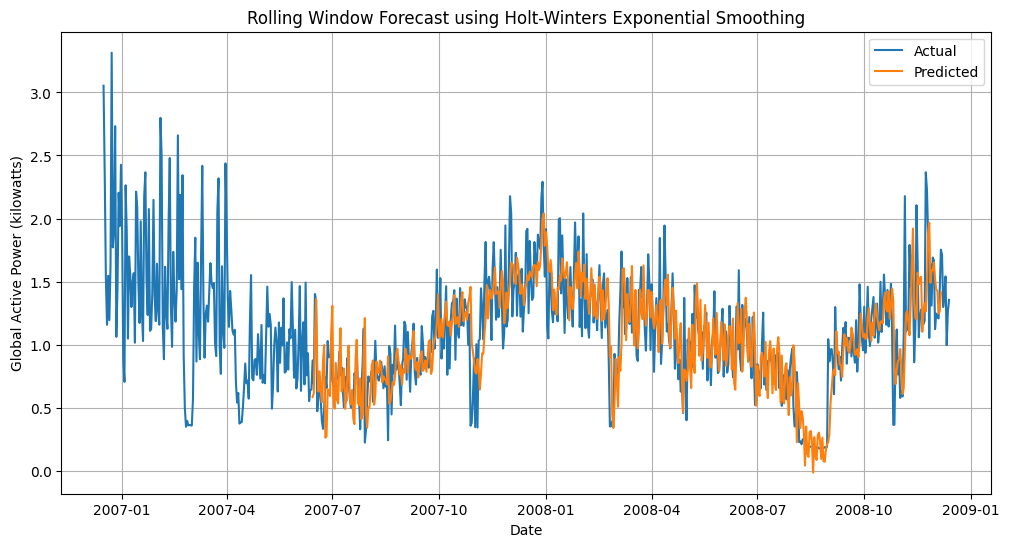

In [ ]:
# Plot actual vs predicted for all predictions
plt.figure(figsize=(12, 6))
plt.plot(data.index, data, label='Actual')
plt.plot(data.index[window_size:-7], daily_preds, label='Predicted')
plt.title('Rolling Window Forecast using Holt-Winters Exponential Smoothing')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kilowatts)')
plt.legend()
plt.grid()
plt.show()